# imports

In [2]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import re
import seaborn as sns
import markdown
import html
from bs4 import BeautifulSoup
import nltk
from nltk import sent_tokenize, word_tokenize
nltk.download('punkt')
from sklearn.preprocessing import PowerTransformer

from torch import no_grad
from transformers import AutoTokenizer, AutoModel

# from transformers import AutoTokenizer, AutoModel
# import tensorflow
import warnings
# import torch
warnings.filterwarnings(action='ignore')
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


PLAN
1. make days since user account creation until post
2. title length
3. body legnth
4. num tags

In [3]:
df = pd.read_csv('data/train-sample.csv')
df.head()

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
0,6046168,05/18/2011 14:14:05,543315,09/17/2010 10:15:06,1,2,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,mongodb,NaN,NaN,NaN,NaN,NaN,open
1,4873911,02/02/2011 11:30:10,465076,10/03/2010 09:30:58,192,24,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,dom,xsd,jaxp,NaN,NaN,NaN,open
2,3311559,07/22/2010 17:21:54,406143,07/22/2010 16:58:20,1,0,Too many lookup tables,What are the adverse effects of having too man...,sql-server,database-design,enums,NaN,NaN,NaN,open
3,9990413,04/03/2012 09:18:39,851755,07/19/2011 10:22:40,4,1,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,php,vb.net,NaN,NaN,NaN,04/15/2012 21:12:48,too localized
4,10421966,05/02/2012 21:25:01,603588,02/04/2011 18:05:34,334,14,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",mongodb,spring-data,NaN,NaN,NaN,NaN,open


# Target

In [4]:
df.OpenStatus.value_counts()

open                   70136
not a real question    30789
off topic              17530
not constructive       15659
too localized           6158
Name: OpenStatus, dtype: int64

# Tags
 - 18308 unique tags

In [5]:
df['numTags'] = df[['Tag1','Tag2','Tag3','Tag4','Tag5']].transpose().notna().sum()
df.numTags.value_counts()

2    37120
3    36276
1    27232
4    23939
5    15701
0        4
Name: numTags, dtype: int64

# AccountAge
Days Since Owner Account Creation Until Post

In [6]:
df[['PostCreationDate','OwnerCreationDate']] = df[['PostCreationDate','OwnerCreationDate']].apply(pd.to_datetime)
df['AccountAge'] = (df['PostCreationDate'] - df['OwnerCreationDate']).dt.days
# drop 60 negative account ages
df = df.loc[df.AccountAge >= 0]
df.AccountAge.describe()

count    140212.000000
mean        215.868171
std         270.062908
min           0.000000
25%           7.000000
50%         103.000000
75%         335.000000
max        1437.000000
Name: AccountAge, dtype: float64

# Reputation

In [7]:
# drop 213 impossible reputation rows < 1
df = df.loc[df.ReputationAtPostCreation > 0]
df.ReputationAtPostCreation.describe()

count    139999.000000
mean        507.606240
std        2498.234813
min           1.000000
25%           1.000000
50%          36.000000
75%         269.000000
max      209631.000000
Name: ReputationAtPostCreation, dtype: float64

# Owner Answer Contibutions
21814 outliers above (20) contributions at the time of post

count    140272.000000
mean          2.225100
std           3.810108
min           0.000000
25%           0.000000
50%           1.000000
75%           2.828427
max          75.973680
Name: OwnerUndeletedAnswerCountAtPostTime, dtype: float64

outlier_upper_bound 7.0710678118654755
num_outliers 11330


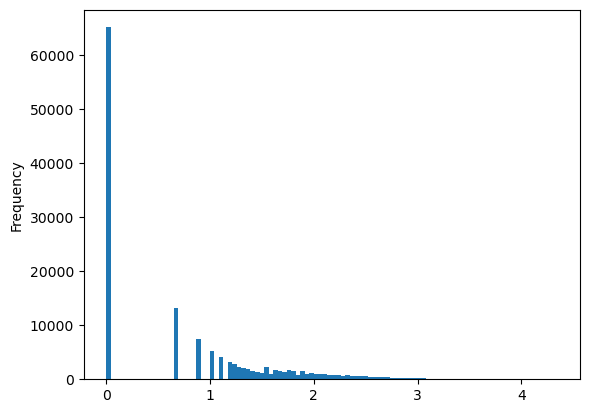

In [7]:
display(df.OwnerUndeletedAnswerCountAtPostTime.describe())
upper_quartile = df.OwnerUndeletedAnswerCountAtPostTime.quantile(.75)
lower_quartile = df.OwnerUndeletedAnswerCountAtPostTime.quantile(.25)
iqr = upper_quartile - lower_quartile
outlier_upper_bound = upper_quartile + 1.5 * (iqr)
print('outlier_upper_bound',outlier_upper_bound)
print('num_outliers', df.loc[df.OwnerUndeletedAnswerCountAtPostTime > outlier_upper_bound].shape[0])
max_ = np.sqrt(df.OwnerUndeletedAnswerCountAtPostTime.max())
df.OwnerUndeletedAnswerCountAtPostTime = (
    df.OwnerUndeletedAnswerCountAtPostTime.map(lambda x: np.log(x+1))
)
df.OwnerUndeletedAnswerCountAtPostTime.plot(kind='hist', bins=100);

# Text Preprocessing
Join tags, title and body as one text input

In [76]:
mask = df[['Tag1','Tag2','Tag3','Tag4','Tag5','Title','BodyMarkdown']].isna()
tag_values = ma.masked_array(df[['Tag1','Tag2','Tag3','Tag4','Tag5','Title','BodyMarkdown']], mask=mask)
df['Text'] = [". ".join(row_tags.compressed()) for row_tags in tag_values]


In [80]:
# make title and body word count features
df['title_wc'] = df.Title.map(lambda x: len(x.split()))
df['body_wc'] = df.BodyMarkdown.map(lambda x: len(x.split()))

# Preprocessing Data

### text cleaning helper functions

In [15]:
def block_code(line):
    if line.startswith('<pre><code'):
        return 1
    elif line.startswith('</code'):
        return -1
    elif line.startswith('<blockquote>'):
        return 2
    elif line.startswith('</blockquote>'):
        return -2
    return 0

def clean_text_from_html_list(html_list):        
    no_code = pd.Series(html_list).map(block_code).to_list()
    for _ in range(df.num_code_blocks.max()):
        try:
            start = no_code.index(1)
            end = no_code.index(-1, start) + 1
            no_code, html_list = no_code[:start] + no_code[end:], html_list[:start] + html_list[end:]
        except ValueError:
            break
    for _ in range(df.num_block_quotes.max()):
        try:
            start = no_code.index(2)
            end = no_code.index(-2, start) + 1
            no_code, test = no_code[:start] + no_code[end:], html_list[:start] + html_list[end:]
        except ValueError:
            break
    # add space to end sentences
    html_list = [f"{line} " for line in html_list]
    # make it one string
    html_str = "".join(html_list)

    # get only text using Beautifulsoup html parser
    text = BeautifulSoup(html_str, 'html.parser').get_text()

    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text.strip()

### Full preprocessing

In [16]:
df = pd.read_csv('data/train-sample.csv')

# drop 213 impossible reputation rows < 1
df = df.loc[df.ReputationAtPostCreation > 0]

# Create no_reputation feature indicating no recognized activity
df['no_reputation'] = df.ReputationAtPostCreation.map(lambda x: int(x == 1))

# create no_contributions to make distinct low activity accounts
df['no_contributions'] = df['OwnerUndeletedAnswerCountAtPostTime'].map(lambda x: int(x==0))

# power transform ReputationAtPostCreation and OwnerUndeletedAnswerCountAtPostTime
df['ReputationAtPostCreation'] = PowerTransformer().fit_transform(df[['ReputationAtPostCreation']])
df['OwnerUndeletedAnswerCountAtPostTime'] = PowerTransformer().fit_transform(df[['OwnerUndeletedAnswerCountAtPostTime']])

# Create account_age feature and drop negative ages and power transform
df[['PostCreationDate','OwnerCreationDate']] = df[['PostCreationDate','OwnerCreationDate']].apply(pd.to_datetime)
df['account_age'] = (df['PostCreationDate'] - df['OwnerCreationDate']).dt.days
df = df.loc[df.account_age >= 0]
df['account_age'] = PowerTransformer().fit_transform(df[['account_age']])

# Create tag text from present tags
mask = df[['Tag1','Tag2','Tag3','Tag4','Tag5']].isna()
df['tag_text'] = [". ".join(row_tags.compressed()) for row_tags in ma.masked_array(df[['Tag1','Tag2','Tag3','Tag4','Tag5']], mask=mask)]

# Create num_tags feature, counting how many tags are used
df['num_tags'] = df[['Tag1','Tag2','Tag3','Tag4','Tag5']].transpose().notna().sum()

# Label encode target
status_id_map = {'open':0, 'not a real question':1,'off topic':2,'not constructive':3,'too localized':4,
                 0:'open', 1:'not a real question',2:'off topic',3:'not constructive',4:'too localized'}
df['target'] = df.OpenStatus.map(status_id_map)

# create list of html lines
df['html_text'] = df.BodyMarkdown.map(lambda x: markdown.markdown(x).split('\n'))

# remove data with bad html parsing
df['num_bad_blocks_v2'] = df.html_text.map(lambda x: len([line for line in x if line.startswith('<code')]) )
df = df.loc[df.num_bad_blocks_v2 < 1]

# count num code blocks in body
df['num_code_blocks'] = df.html_text.map(lambda x: len([line for line in x if line.startswith('<pre><code')]) )
df['num_code_blocks_end'] = df.html_text.map(lambda x: len([line for line in x if line.startswith('</code')]) )
df = df.loc[(df.num_code_blocks - df.num_code_blocks_end) == 0]

# count num block quotes in body
df['num_block_quotes'] = df.html_text.map(lambda x: len([line for line in x if line.startswith('<blockquote')]) )
df['num_block_quotes_end'] = df.html_text.map(lambda x: len([line for line in x if line.startswith('</blockquote')]) )
df = df.loc[(df.num_block_quotes - df.num_block_quotes_end) == 0]

# create preprocessed text removing code blocks
df['clean_text'] = df.html_text.map(clean_text_from_html_list)

# count num links in body
df['num_links'] = df.clean_text.map(lambda x: len(re.findall(r'http',x)))

# Lists of sentences in body and title
df['body_sentences'] = df.clean_text.map(lambda x: sent_tokenize(x))
df['title_sentences'] = df.Title.map(lambda x: sent_tokenize(x))
# sentence counts of body and title
df['num_body_sentences'] = df.body_sentences.map(lambda x: len(x))
df['num_title_sentences'] = df.title_sentences.map(lambda x: len(x))
# word counts of body and title
df['num_body_words'] = df.clean_text.map(lambda x: len(word_tokenize(x)))
df['num_title_words'] = df.Title.map(lambda x: len(word_tokenize(x)))
# body character count
df['num_body_chars'] = df.clean_text.map(lambda x: len(x))

# num sentences starting with "I" in body and title
df['num_I_body_start'] = df.body_sentences.map(lambda x: sum([sent.startswith('i ') or sent.startswith("i'") for sent in x]))
df['num_I_title_start'] = df.title_sentences.map(lambda x: sum([sent.startswith('i ') or sent.startswith("i'") for sent in x]))
df['num_I_start'] = df.num_I_body_start + df.num_I_title_start

# num sentences starting with "you" in body and title
df['num_you_body_start'] = df.body_sentences.map(lambda x: sum([sent.startswith('you ') or sent.startswith("you'") for sent in x]))
df['num_you_title_start'] = df.title_sentences.map(lambda x: sum([sent.startswith('you ') or sent.startswith("you'") for sent in x]))
df['num_you_start'] = df.num_you_body_start + df.num_you_title_start

# combined title and body strings
df['title_body_text'] = [". ".join([title,body]) for title, body in zip(df.Title,df.clean_text)]

# num of interrogatory words in combined text
df['num_who'] = df.title_body_text.map(lambda x: len(re.findall(r'who ',x)))
df['num_what'] = df.title_body_text.map(lambda x: len(re.findall(r'what ',x)))
df['num_when'] = df.title_body_text.map(lambda x: len(re.findall(r'when ',x)))
df['num_where'] = df.title_body_text.map(lambda x: len(re.findall(r'where ',x)))
df['num_why'] = df.title_body_text.map(lambda x: len(re.findall(r'why ',x)))
df['num_whose'] = df.title_body_text.map(lambda x: len(re.findall(r'whose ',x)))
df['num_which'] = df.title_body_text.map(lambda x: len(re.findall(r'which ',x)))
df['num_how'] = df.title_body_text.map(lambda x: len(re.findall(r'how ',x)))

# make all numeric cols floats
for col in df.select_dtypes(int,float).columns:
    df[col] = df[col].astype(np.float32)

# create final text for embedding
df['text'] = [". ".join([tag_text,post_text]) for tag_text, post_text in zip(df.tag_text,df.title_body_text)]


In [17]:
df.columns

Index(['PostId', 'PostCreationDate', 'OwnerUserId', 'OwnerCreationDate',
       'ReputationAtPostCreation', 'OwnerUndeletedAnswerCountAtPostTime',
       'Title', 'BodyMarkdown', 'Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5',
       'PostClosedDate', 'OpenStatus', 'no_reputation', 'no_contributions',
       'account_age', 'tag_text', 'num_tags', 'target', 'html_text',
       'num_bad_blocks_v2', 'num_code_blocks', 'num_code_blocks_end',
       'num_block_quotes', 'num_block_quotes_end', 'clean_text', 'num_links',
       'body_sentences', 'title_sentences', 'num_body_sentences',
       'num_title_sentences', 'num_body_words', 'num_title_words',
       'num_body_chars', 'num_I_body_start', 'num_I_title_start',
       'num_I_start', 'num_you_body_start', 'num_you_title_start',
       'num_you_start', 'title_body_text', 'num_who', 'num_what', 'num_when',
       'num_where', 'num_why', 'num_whose', 'num_which', 'num_how', 'text'],
      dtype='object')

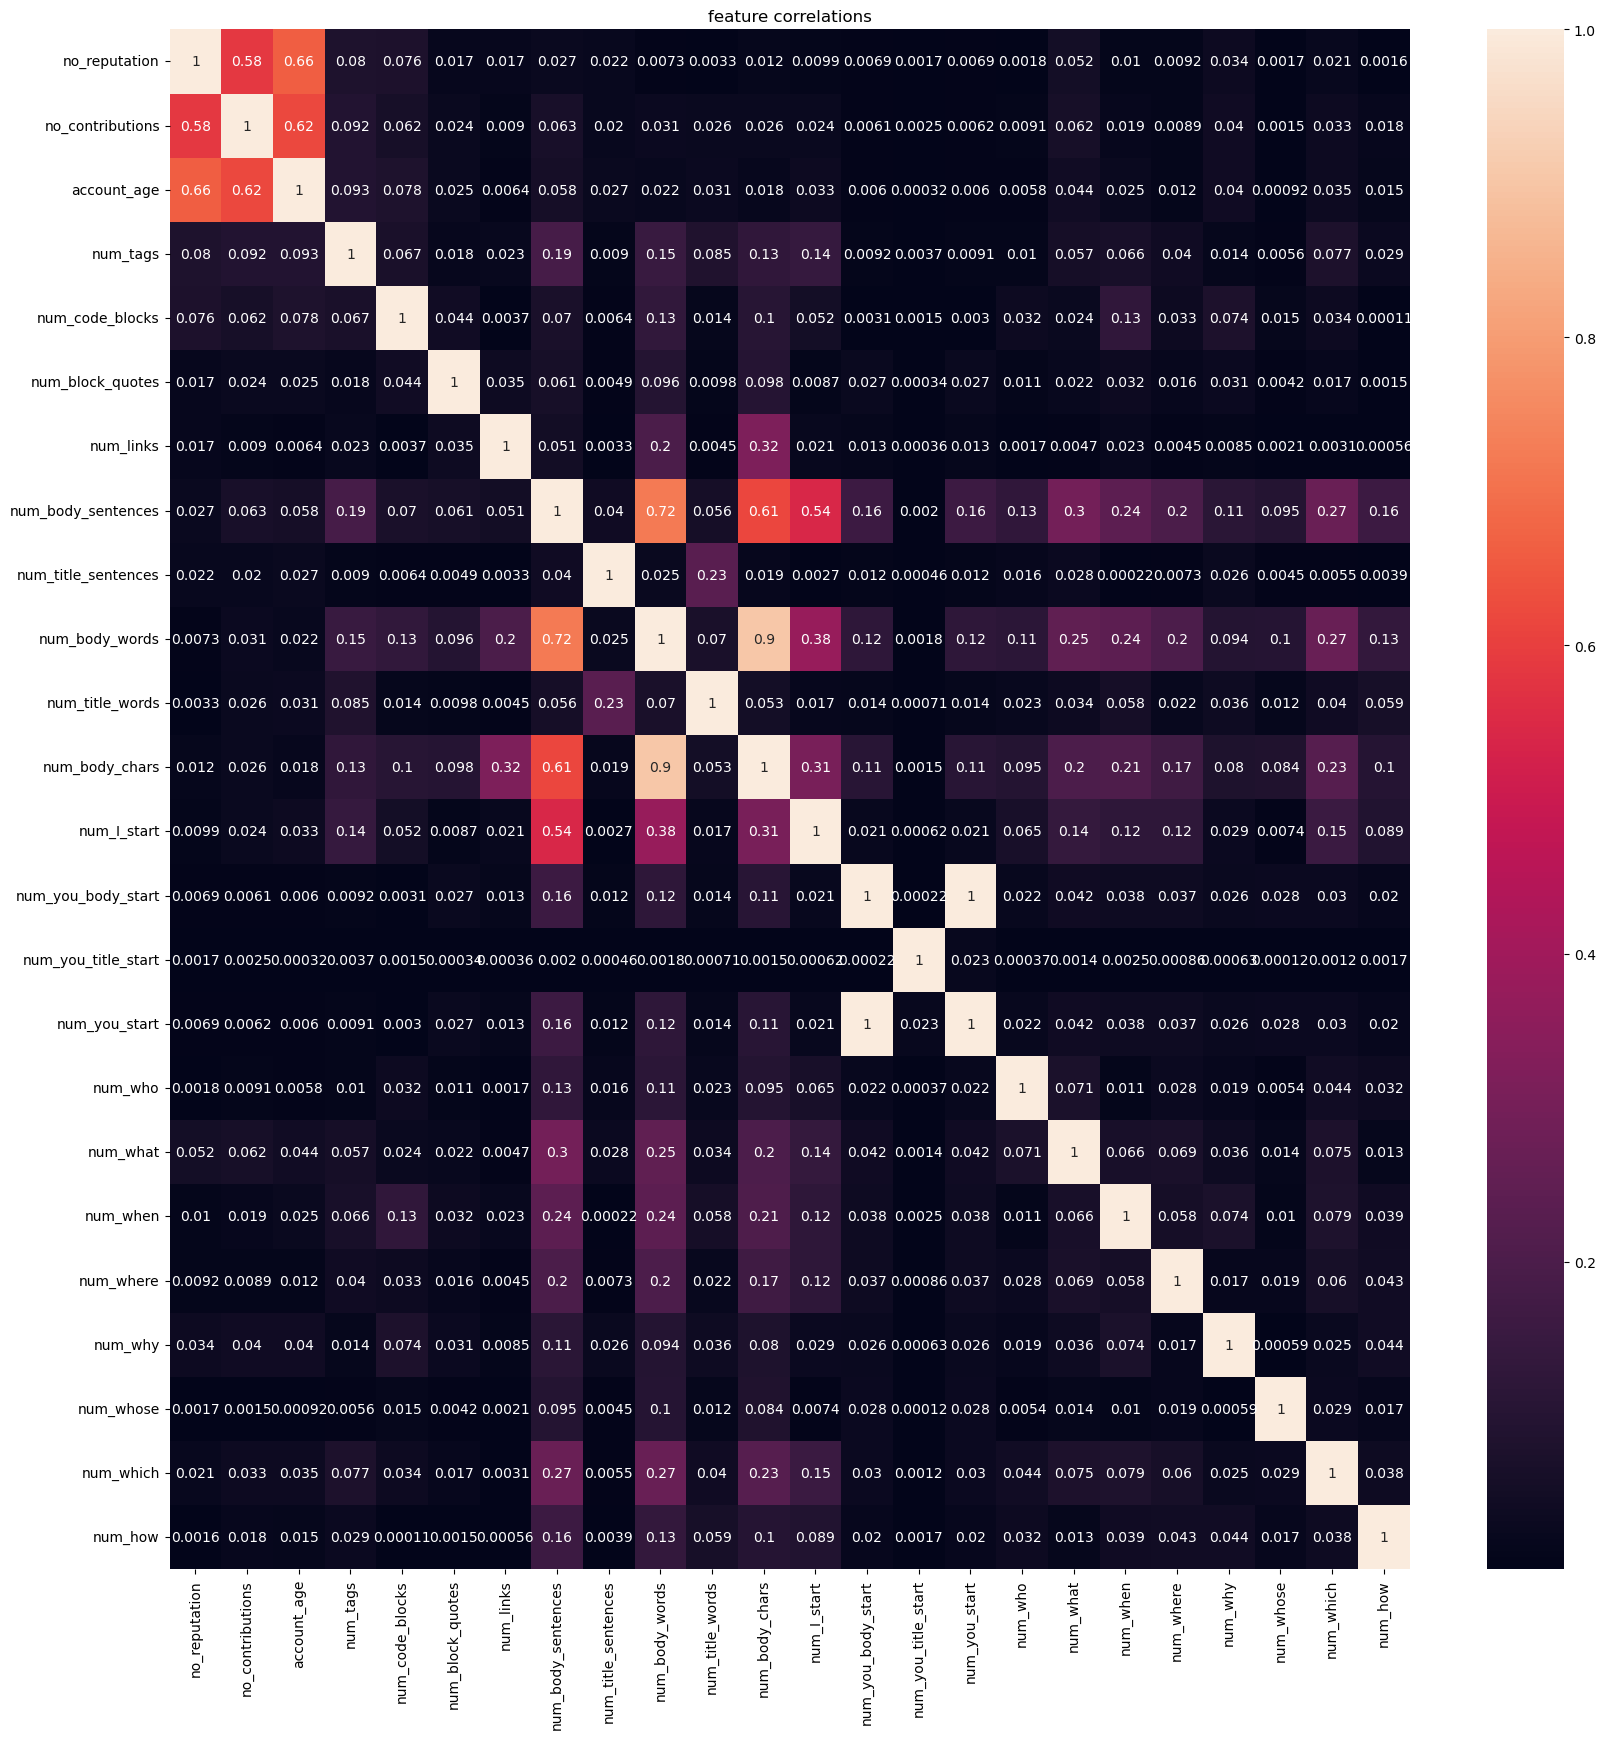

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
corr_cols = ['no_reputation', 'no_contributions',
       'account_age', 'num_tags', 'num_code_blocks',
       'num_block_quotes', 'num_links',
       'num_body_sentences',
       'num_title_sentences', 'num_body_words', 'num_title_words',
       'num_body_chars',
       'num_I_start', 'num_you_body_start', 'num_you_title_start',
       'num_you_start', 'num_who', 'num_what', 'num_when',
       'num_where', 'num_why', 'num_whose', 'num_which', 'num_how']
sns.heatmap(np.abs(df[corr_cols].astype(np.float32).corr()), annot=True,ax=ax)
plt.title('feature correlations');

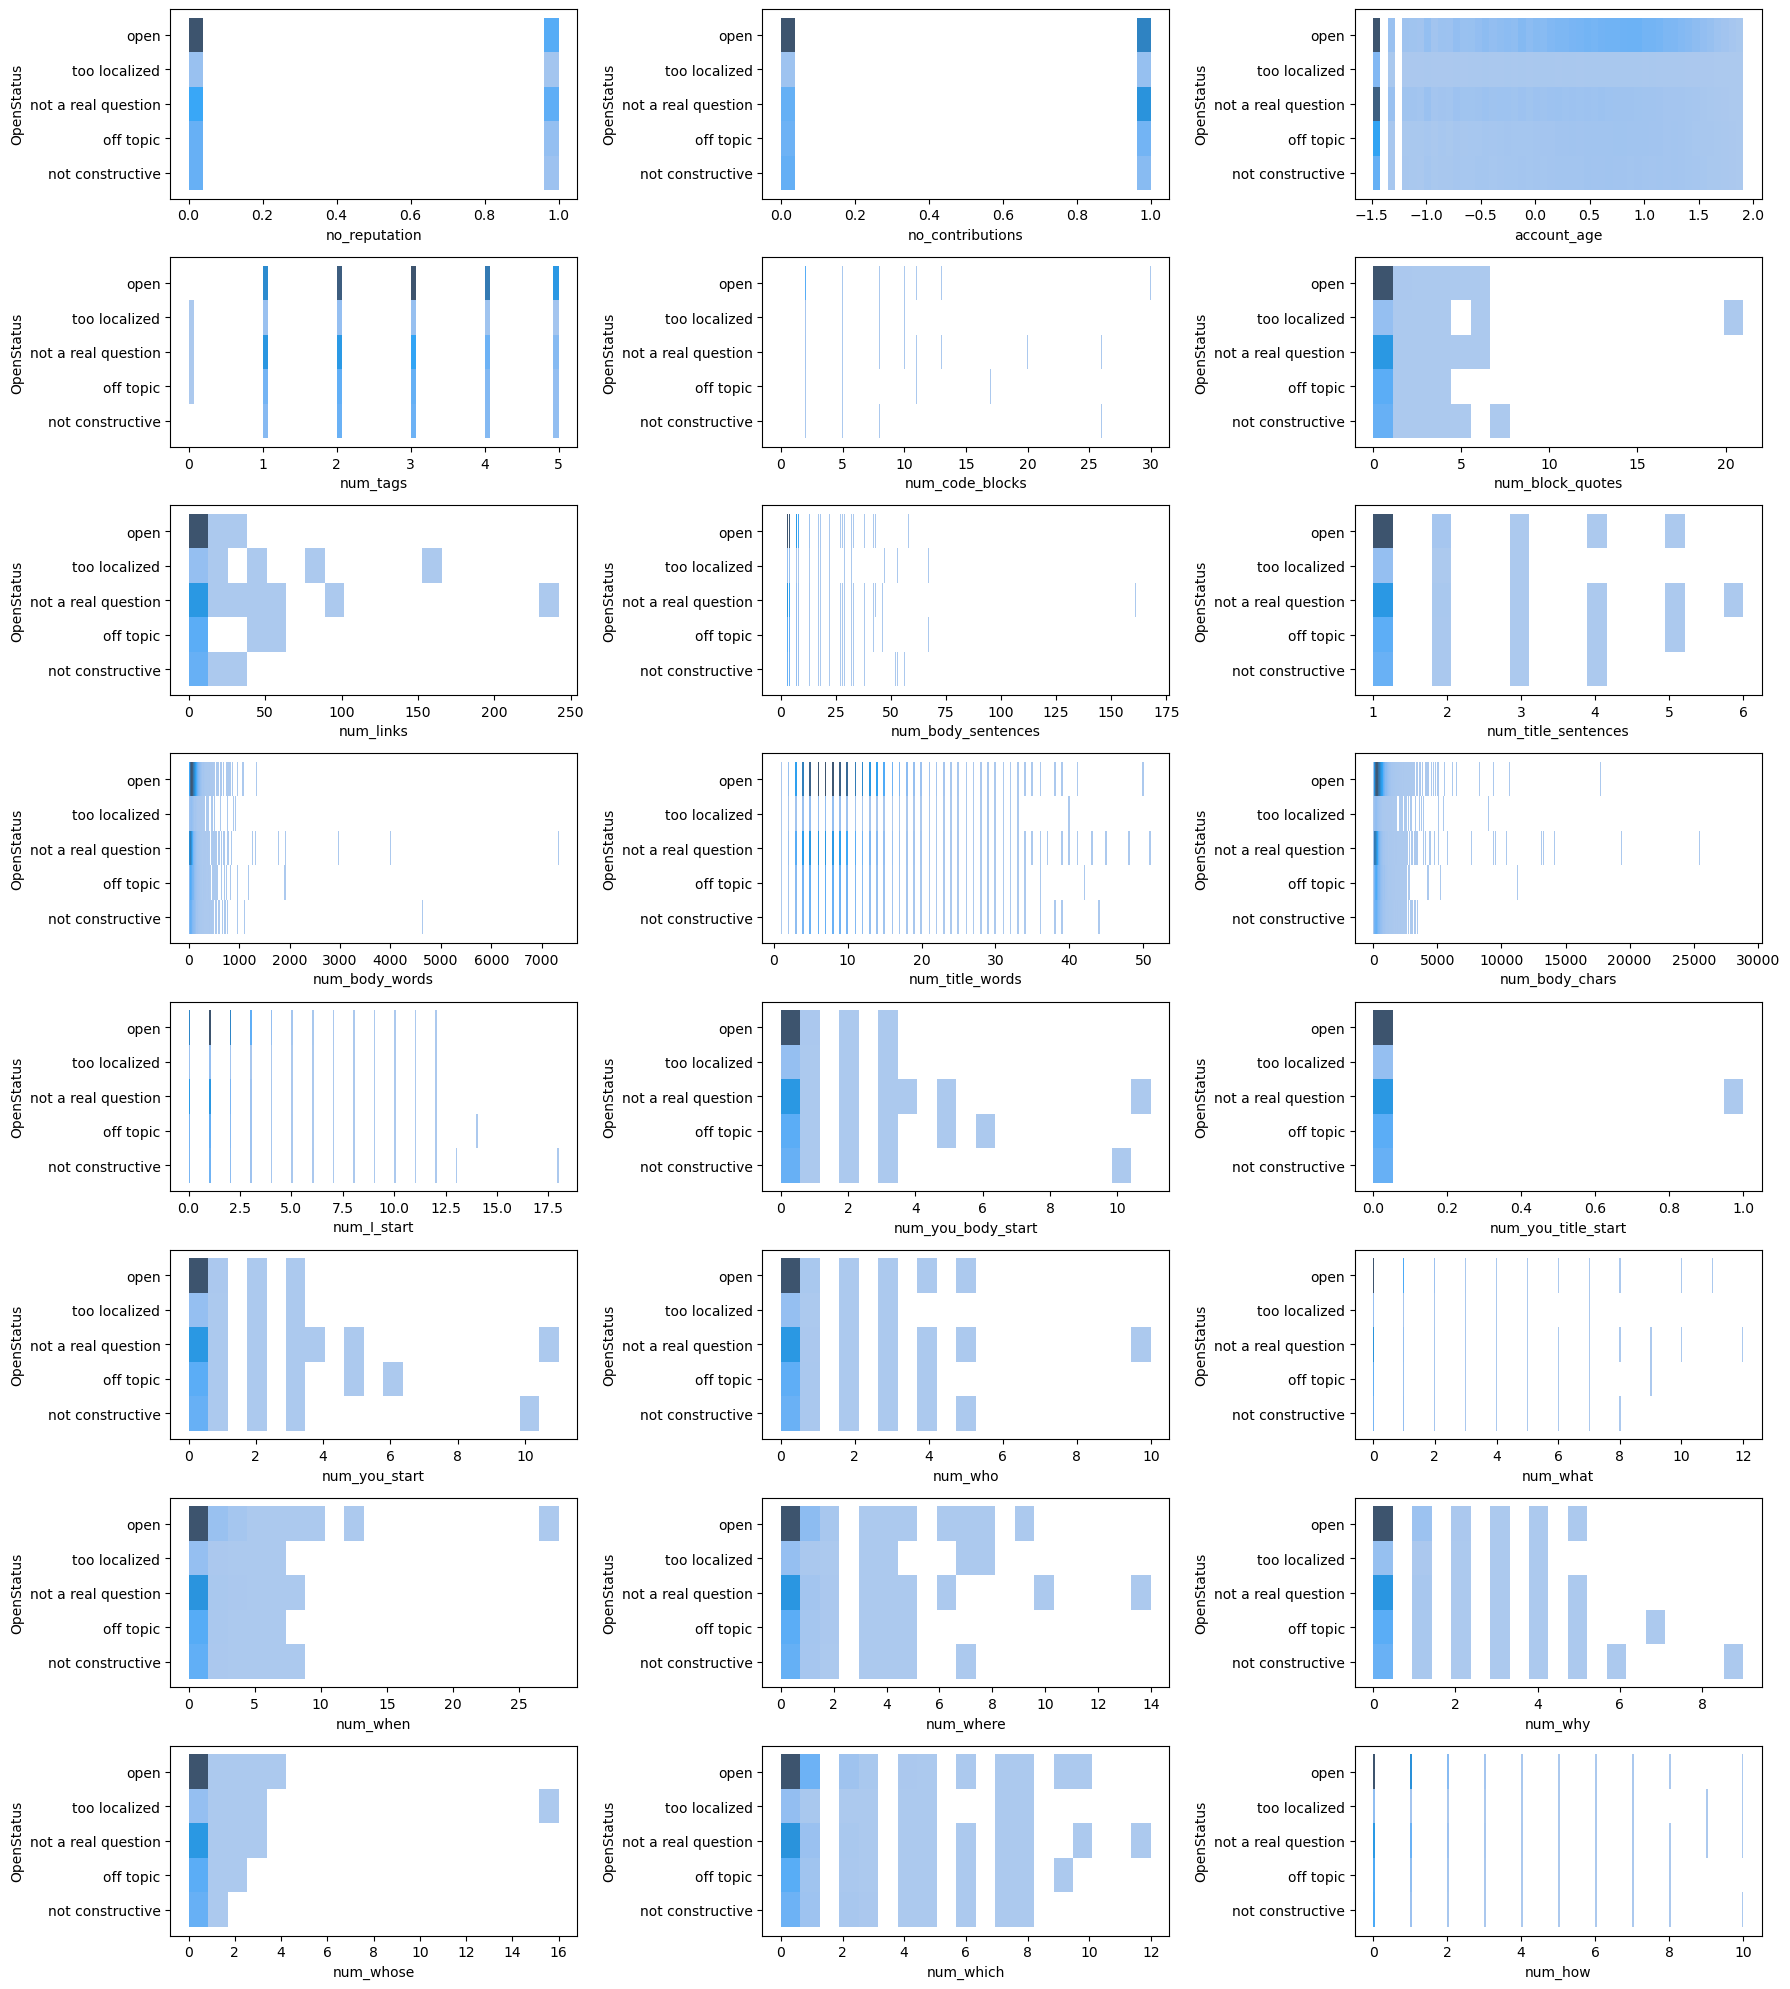

In [105]:
pairplot_cols = ['no_reputation', 'no_contributions',
                    'account_age', 'num_tags', 'num_code_blocks',
                    'num_block_quotes', 'num_links',
                    'num_body_sentences',
                    'num_title_sentences', 'num_body_words', 'num_title_words',
                    'num_body_chars',
                    'num_I_start', 'num_you_body_start', 'num_you_title_start',
                    'num_you_start', 'num_who', 'num_what', 'num_when',
                    'num_where', 'num_why', 'num_whose', 'num_which', 'num_how']

fig = plt.figure(figsize=(18,20))
for i, col in enumerate(pairplot_cols):
    ax = plt.subplot(8,3,i+1)
    sns.histplot(x=df[col],y=df.OpenStatus,ax=ax).set(xlabel=col)
plt.tight_layout()
plt.show()

### save pre-embedded to csv

In [11]:
save_cols = [
    'ReputationAtPostCreation', 
    'OwnerUndeletedAnswerCountAtPostTime',
    'OpenStatus', 
    'no_reputation', 
    'no_contributions',
    'account_age',
    'num_tags',
    'num_code_blocks', 
    'num_block_quotes','num_links',
    'num_body_sentences',
    'num_title_sentences', 
    'num_body_words', 
    'num_title_words',
    'num_body_chars',
    'num_I_start',
    'num_you_start', 
    'num_who', 
    'num_what', 
    'num_when',
    'num_where', 
    'num_why',
    'num_whose', 
    'num_which', 
    'num_how', 
    'text']

df[save_cols].to_csv('data/preprocessed.csv')

### embeddings

In [12]:
# load data
df = pd.read_csv('data/preprocessed.csv', index_col=0)

# Create word embedding features from Text
embedding_magnitude = 768
display('shape before dropping long texts:',df.shape)
embeddings = np.zeros((df.shape[0], embedding_magnitude))

tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")
model = AutoModel.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")

with no_grad():
    for i, text in enumerate(df.text):
        # print status
        print(i,"/",df.shape[0])

        # get tokens
        inputs = tokenizer(text, return_tensors="pt")

        # nan rows with too many tokens
        if inputs['input_ids'].shape[1] > 512:
            embeddings[i,:] = np.array([np.nan]*embedding_magnitude)
            continue
        out = model(**inputs)['pooler_output']
        embeddings[i,:] = np.array(out)

df = pd.concat((df.drop(columns='text'),pd.DataFrame(embeddings,columns=[f"emb_{i}" for i in range(embedding_magnitude)])), axis=1).dropna()
df.reset_index(drop=True, inplace=True)


'shape before dropping long texts:'

(139174, 26)

0 / 139174
1 / 139174
2 / 139174
3 / 139174
4 / 139174
5 / 139174
6 / 139174
7 / 139174
8 / 139174
9 / 139174
10 / 139174
11 / 139174
12 / 139174
13 / 139174
14 / 139174
15 / 139174
16 / 139174
17 / 139174
18 / 139174
19 / 139174
20 / 139174
21 / 139174
22 / 139174
23 / 139174
24 / 139174
25 / 139174
26 / 139174
27 / 139174
28 / 139174
29 / 139174
30 / 139174
31 / 139174
32 / 139174
33 / 139174
34 / 139174
35 / 139174
36 / 139174
37 / 139174
38 / 139174
39 / 139174
40 / 139174
41 / 139174
42 / 139174
43 / 139174
44 / 139174
45 / 139174
46 / 139174
47 / 139174
48 / 139174
49 / 139174
50 / 139174
51 / 139174
52 / 139174
53 / 139174
54 / 139174
55 / 139174
56 / 139174


Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


57 / 139174
58 / 139174
59 / 139174
60 / 139174
61 / 139174
62 / 139174
63 / 139174
64 / 139174
65 / 139174
66 / 139174
67 / 139174
68 / 139174
69 / 139174
70 / 139174
71 / 139174
72 / 139174
73 / 139174
74 / 139174
75 / 139174
76 / 139174
77 / 139174
78 / 139174
79 / 139174
80 / 139174
81 / 139174
82 / 139174
83 / 139174
84 / 139174
85 / 139174
86 / 139174
87 / 139174
88 / 139174
89 / 139174
90 / 139174
91 / 139174
92 / 139174
93 / 139174
94 / 139174
95 / 139174
96 / 139174
97 / 139174
98 / 139174
99 / 139174
100 / 139174
101 / 139174
102 / 139174
103 / 139174
104 / 139174
105 / 139174
106 / 139174
107 / 139174
108 / 139174
109 / 139174
110 / 139174
111 / 139174
112 / 139174
113 / 139174
114 / 139174
115 / 139174
116 / 139174
117 / 139174
118 / 139174
119 / 139174
120 / 139174
121 / 139174
122 / 139174
123 / 139174
124 / 139174
125 / 139174
126 / 139174
127 / 139174
128 / 139174
129 / 139174
130 / 139174
131 / 139174
132 / 139174
133 / 139174
134 / 139174
135 / 139174
136 / 139174
137

KeyboardInterrupt: 